In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
print(os.getcwd())
today = datetime.today().strftime("%Y%m%d")

hist_fname = f"Realisierter_Stromverbrauch_201501010000_202310312359_Viertelstunde.csv"
recent_fname = f"Realisierter_Stromverbrauch_202311010000_{today}2359_Viertelstunde.csv"

# Check if file exists first before loading data
if not os.path.isfile(f"./data/{recent_fname}"):
    print(f"{recent_fname} does not exist, first download data from SMARD !")
    
# Load data
hist_df = pd.read_csv(f"./data/{hist_fname}", sep=";", decimal=",")
recent_df = pd.read_csv(f"./data/{recent_fname}", sep=";", decimal=",")

# merge 2 dataframes
df = pd.concat([hist_df, recent_df])

# Rename columns for convenience
df.columns = ["datum", "anfang", "ende", "gesamt", "residual", "pump"]

# replace '-' with NA
df.replace('-', pd.NA, inplace=True)

# Merge date and time column and set that as the index
df["timestamp"] = pd.to_datetime(df['datum'] + ' ' + df['anfang'], format='%d.%m.%Y %H:%M')

# need to choose anfang here !!!
# otherwise in DST switching end of march we will have 3am twice

# change datetime to utc time
df['timestamp_CET'] = df['timestamp'].dt.tz_localize('CET', ambiguous='infer')
df['timestamp_UTC'] = df['timestamp_CET'].dt.tz_convert('UTC')
df.set_index("timestamp_UTC", inplace=True)

df_utc = df[['gesamt', 'timestamp_CET']].copy()

# Replace "." with "" and then replace "," with "."
df_utc[['gesamt']] = df_utc[['gesamt']].apply(lambda x: x.str.replace('.', '', regex=False))
df_utc[['gesamt']] = df_utc[['gesamt']].apply(lambda x: x.str.replace(',', '.', regex=False))
df_utc[['gesamt']] = df_utc[['gesamt']].apply(pd.to_numeric)

# if there are consecutive trailing NaNs, drop them ... find last valid index
last_valid_index = df_utc['gesamt'].last_valid_index()

if last_valid_index is not None:
    df_utc = df_utc.loc[:last_valid_index]

print(f"{df_utc['gesamt'].isna().sum()} NA in df")

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
27 NA in df


In [12]:
df_utc[df_utc['gesamt'].isna()]

,gesamt,timestamp_CET
timestamp_UTC,,
2023-12-15 16:15:00+00:00,NaN,2023-12-15 17:15:00+01:00
2023-12-15 16:30:00+00:00,NaN,2023-12-15 17:30:00+01:00
2023-12-15 16:45:00+00:00,NaN,2023-12-15 17:45:00+01:00
2023-12-15 17:00:00+00:00,NaN,2023-12-15 18:00:00+01:00
2023-12-15 17:15:00+00:00,NaN,2023-12-15 18:15:00+01:00
2023-12-15 17:30:00+00:00,NaN,2023-12-15 18:30:00+01:00
2023-12-15 17:45:00+00:00,NaN,2023-12-15 18:45:00+01:00
2023-12-15 18:00:00+00:00,NaN,2023-12-15 19:00:00+01:00
2023-12-15 18:15:00+00:00,NaN,2023-12-15 19:15:00+01:00


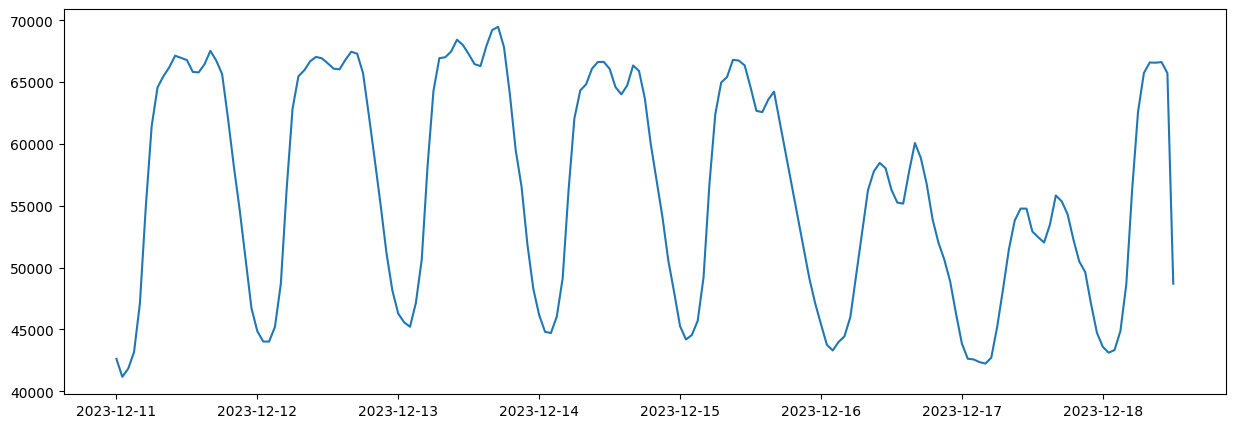

In [9]:
# Interpolate missing values in between
df_utc_interp = df_utc.copy()
df_utc_interp['gesamt'].interpolate(method='linear', inplace=True)

df_hourly = df_utc_interp.resample("1h", label="left").agg({'gesamt':'sum','timestamp_CET':'first'})

# Add weekday column
df_hourly["weekday"] = df_hourly['timestamp_CET'].dt.weekday # Monday=0, Sunday=6

plt.figure(figsize=(15, 5))
plt.plot(df_hourly[(df_hourly.index.year == 2023) & (df_hourly.index.month == 12) & (df_hourly.index.day > 10)]['gesamt'])
plt.show()